# Fine-Tuning GPT-2 for Subject Classification

This project demonstrates how to fine-tune a pre-trained GPT-2 model for the task of classifying student questions into four subjects: **Maths, Chemistry, Physics, and Biology**. The workflow covers data preparation, model adaptation, training, evaluation, and inference.

---

## Project Workflow

### 1. **Data Preparation**
- **Dataset:** Student questions dataset from Kaggle, containing questions labeled by subject.
- **Balancing:** The dataset is imbalanced (Biology has more entries). We balance it by random sampling so each subject has an equal number of examples.
- **Label Encoding:** Subject names are mapped to numerical labels:  
    `Maths: 0, Chemistry: 1, Physics: 2, Biology: 3`
- **Splitting:** The data is split into training (70%), validation (10%), and test (20%) sets.
- **Saving:** Each split is saved as a CSV file for reproducibility.

### 2. **Tokenization & Dataset Class**
- **Tokenizer:** Uses GPT-2's `tiktoken` tokenizer to encode questions.
- **Custom Dataset:** Implements a PyTorch `Dataset` class to handle tokenization, padding, and loading of data for training.

### 3. **Model Preparation**
- **Model Loading:** Downloads and loads the pre-trained GPT-2 model weights.
- **Model Modification:**  
    - The output head is replaced with a linear layer for 4-class classification.
    - All model parameters are frozen except the output head and the last transformer block (and optionally the final normalization layer) to allow efficient fine-tuning.

### 4. **Training**
- **Loss & Accuracy Functions:** Custom functions for calculating cross-entropy loss and accuracy.
- **Training Loop:**  
    - Uses AdamW optimizer.
    - Tracks and prints training/validation loss and accuracy.
    - Evaluates model performance at regular intervals.
- **Saving:** The trained model is saved for later inference.

### 5. **Evaluation & Visualization**
- **Accuracy:** Evaluates the model on training, validation, and test sets.
- **Visualization:** Plots loss and accuracy curves over epochs and examples seen.

### 6. **Inference**
- **Classification Function:** Provides a function to classify new questions into one of the four subjects.
- **Testing:** Demonstrates the classifier on sample questions.

---

## Results

- **Training Accuracy:** ~91%
- **Validation Accuracy:** ~90%
- **Test Accuracy:** ~90%

The fine-tuned GPT-2 model achieves high accuracy in classifying student questions by subject, demonstrating the effectiveness of transfer learning and transformer-based models for text classification tasks.

---

## Key Takeaways

- **Transfer Learning:** Leveraging pre-trained language models like GPT-2 enables efficient adaptation to downstream tasks with limited labeled data.
- **Balanced Data:** Addressing class imbalance is crucial for fair and robust classification.
- **Layer Freezing:** Fine-tuning only the output head and last transformer block preserves pre-trained knowledge while adapting to new tasks.
- **Reproducibility:** Saving splits and model weights ensures results can be reproduced and extended.

---

**This notebook provides a complete, reproducible pipeline for fine-tuning GPT-2 on a real-world text classification problem.**

In [2]:
!pip install tiktoken
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024) // you can increase this if you have more memory
    "emb_dim": 768,        # Embedding dimension // we change this later to 4 for classification of 4 classes
    "n_heads": 12,         # Number of attention heads 
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.2,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [4]:
import torch.nn as nn
import torch
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [7]:
import torch.nn as nn
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [8]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [9]:
import os
import requests  # Make sure requests is installed
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    ## We have reached here until now ---> we have downloaded the files on our local machine.

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

def download_file(url, destination):
    try:
        # Send a GET request to download the file, disabling SSL verification
        response = requests.get(url, stream=True, verify=False)

        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("content-length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = url.split("/")[-1]  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Iterate over the file data in chunks
                for chunk in response.iter_content(block_size):
                    progress_bar.update(len(chunk))  # Update progress bar
                    file.write(chunk)  # Write the chunk to the file

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        print(f"Please check the URL: {url}")

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


In [10]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [11]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [12]:
torch.manual_seed(123)
# !pip install tiktoken
import tiktoken
tokenizer= tiktoken.get_encoding("gpt2")
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)" 
# You can change this to "gpt2-medium (355M)", "gpt2-large (774M)", or "gpt2-xl (1558M)" to use a different model   
INPUT_PROMPT = "Every effort moves" 

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [14]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 148kiB/s]
/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.44MiB/s]
/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [15]:
text_1 = "How to be happy?"
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=70,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

How to be happy?

The answer is simple: you can't be happy.

The good news is that you can be happy.

The bad news is that you can't be happy.

The good news is that you can't be happy.

The good news is that you can't be happy.

The good news is


In [ ]:
import kagglehub #run this command to install kagglehub, try running this on kaggle
# Download latest version . this dataset is used for fine-tuning the model , its a dataset of questions asked by students preparing for IIT JEE, NEET, and AIMS exams
path = kagglehub.dataset_download("mrutyunjaybiswal/iitjee-neet-aims-students-questions-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iitjee-neet-aims-students-questions-data


In [ ]:
import pandas as pd
# Load the dataset
data=pd.read_csv("/kaggle/input/iitjee-neet-aims-students-questions-data/subjects-questions.csv")
# Display unique subjects and count of entries
print(data["Subject"].unique())
# Display the count of entries in the dataset
# This will show how many questions are available for each subject
print(data.count())
# print(data["eng"])

['Biology' 'Chemistry' 'Maths' 'Physics']
eng        122519
Subject    122519
dtype: int64


In [ ]:
# print(data["Subject"])
print(data["Subject"].value_counts())

Subject
Physics      38438
Chemistry    37767
Maths        33190
Biology      13124
Name: count, dtype: int64


In [ ]:
#This dataset is imbalanced, with "Biology" having significantly more entries than the other subjects.
# To address this, we will create a balanced dataset by randomly sampling the other subjects to match the number of entries in "Biology".
def create_balanced_dataset(df):
    # Count the instances of "Biology" subject
    num_spam = df[df["Subject"] == "Biology"].shape[0]
    #random sampling using .sample() function
    Maths_subset=df[df["Subject"]=="Maths"].sample(num_spam,random_state=123)
    Chemistry_subset=df[df["Subject"]=="Chemistry"].sample(num_spam,random_state=123)
    Physics_subset=df[df["Subject"]=="Physics"].sample(num_spam,random_state=123)
    
    #lastly concatenate all of them . now we will get 13124 of all of them
    balanced_df = pd.concat([Maths_subset,Chemistry_subset,Physics_subset, df[df["Subject"] == "Biology"]])
    return balanced_df

balanced_df = create_balanced_dataset(data)
print(balanced_df["Subject"].value_counts())

Subject
Maths        13124
Chemistry    13124
Physics      13124
Biology      13124
Name: count, dtype: int64


In [ ]:
# Convert the subject names to numerical labels for classification
# This is a common practice in machine learning to convert categorical variables into numerical format.
balanced_df["Subject"] = balanced_df["Subject"].map({"Maths": 0, "Chemistry": 1,"Physics":2,"Biology":3})

In [ ]:
#70% for training , 20% for testing , 10% for validation 
## We will use a random split to create the train, validation, and test sets.
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is to be 0.2 as the remainder
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


In [ ]:
# print the number of entries in each dataset
print(len(train_df))
print(len(validation_df))
print(len(test_df))

36747
5249
10500


In [ ]:
#save these data to the csv files to load them later
train_df.to_csv("subjects_train.csv", index=None)
validation_df.to_csv("subjects_validation.csv", index=None)
test_df.to_csv("subjects_test.csv", index=None)

In [ ]:
import torch
from torch.utils.data import Dataset

# Define a custom dataset class for the subjects dataset
#The functions in this class will help us to load the data from the csv files and convert them into tensors that can be used for training the model.
#basically it will help tokenize the text and convert it into tensors
class SubjectsDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["eng"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Subject"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [ ]:
# Load the dataset
train_dataset = SubjectsDataset(
    csv_file="subjects_train.csv",
    max_length=None,
    tokenizer=tokenizer
)

# print(train_dataset.max_length)
val_dataset = SubjectsDataset(
    csv_file="subjects_validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SubjectsDataset(
    csv_file="subjects_test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [ ]:
from torch.utils.data import DataLoader
# Create DataLoaders for training, validation, and test datasets
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [ ]:
#In this step we freeze the model parameters so that they are not updated during training.
# This is useful when we want to fine-tune the model on a specific task without changing
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Set the output head for classification
# We will change the output head to have 4 classes for classification
torch.manual_seed(123)
num_classes = 4
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [ ]:
# Freeze all parameters except the output head and the last transformer block
# This allows the model to retain its pre-trained knowledge while adapting to the new classification task.
#you can also try experimenting with freezing more layers, but this is a good starting point
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
# for param in model.trf_blocks[-2].parameters():
#     param.requires_grad= True
# for param in model.trf_blocks[-3].parameters():
#     param.requires_grad=True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
# Print the model architecture to verify the changes
inputs = tokenizer.encode("what is LLM")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[10919,   318, 27140,    44]])
Inputs dimensions: torch.Size([1, 4])


In [ ]:
# Model inference
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.6141,  1.2282,  0.3008, -0.5369],
         [-1.8646,  5.9696,  2.7381, -0.5265],
         [-3.6957,  3.4373,  0.6597, -1.2068],
         [-3.2174,  4.3485,  2.2180, -0.3779]]])
Outputs dimensions: torch.Size([1, 4, 4])


In [ ]:
# Function to calculate accuracy for a single batch

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [ ]:
# Print the last output token, we take the probabilities of the last output token with the softmax function
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.2174,  4.3485,  2.2180, -0.3779]])


In [ ]:
# Evaluate the model without training
# This will give us the accuracy of the model on the training, validation, and test datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device) 
torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

cuda
Training accuracy: 20.00%
Validation accuracy: 23.75%
Test accuracy: 38.75%


In [35]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [36]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [37]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 4.230
Validation loss: 3.758
Test loss: 3.539


In [ ]:
# Training loop
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
# Evaluate the model
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
# Train the model, we will use the AdamW optimizer with a learning rate of 5e-5 and weight decay of 0.1
#experiment with different learning rates and weight decay values to see how it affects the training

import time
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.696, Val loss 3.499
Ep 1 (Step 000050): Train loss 1.390, Val loss 1.331
Ep 1 (Step 000100): Train loss 1.345, Val loss 1.307
Ep 1 (Step 000150): Train loss 1.320, Val loss 1.280
Ep 1 (Step 000200): Train loss 1.316, Val loss 1.257
Ep 1 (Step 000250): Train loss 1.310, Val loss 1.266
Ep 1 (Step 000300): Train loss 1.266, Val loss 1.236
Ep 1 (Step 000350): Train loss 1.344, Val loss 1.284
Ep 1 (Step 000400): Train loss 1.393, Val loss 1.292
Ep 1 (Step 000450): Train loss 1.234, Val loss 1.273
Ep 1 (Step 000500): Train loss 1.366, Val loss 1.262
Ep 1 (Step 000550): Train loss 1.334, Val loss 1.258
Ep 1 (Step 000600): Train loss 1.230, Val loss 1.261
Ep 1 (Step 000650): Train loss 1.366, Val loss 1.223
Ep 1 (Step 000700): Train loss 1.208, Val loss 1.213
Ep 1 (Step 000750): Train loss 1.295, Val loss 1.236
Ep 1 (Step 000800): Train loss 1.249, Val loss 1.232
Ep 1 (Step 000850): Train loss 1.264, Val loss 1.254
Ep 1 (Step 000900): Train loss 1.192, Val loss

In [ ]:
#the most important part is to save the model after training so that we can use it later for inference
# Save the model state dictionary to a file
torch.save(model.state_dict(), "Subject_classifier.pth")

In [ ]:
# Load the model state dictionary from the file
model_state_dict = torch.load("Subject_classifier.pth")
model.load_state_dict(model_state_dict)

/tmp/ipykernel_30/3757124446.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("Subject_classifier.pth")


<All keys matched successfully>

In [ ]:
# Plot the loss and accuracy values
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

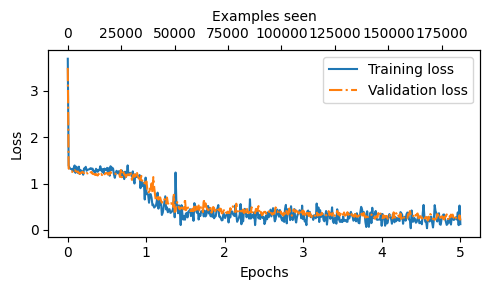

In [ ]:
# Plot the loss and accuracy values
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [ ]:
# this function will classify the subject of a given text using the trained model
# It takes the text as input and returns the predicted subject as a string.
def classify_subject(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()
    # print(predicted_label)
    # Return the classified result
    # "Maths": 0, "Chemistry": 1,"Physics":2,"Biology":3
    return (
    "Maths" if predicted_label == 0 else
    "Chemistry" if predicted_label == 1 else
    "Physics" if predicted_label == 2 else
    "Biology"
)


In [ ]:
#HERE we will test the model on some sample texts to see how well it classifies the subjects
# You can change the texts to test the model on different inputs.
text_1 = (
    "How the gravitational constant will change if a brass plate is introduced between two bodies?"
)
text_2=(
    """A ketone has molar mass 86 Which of the following cannot be IUPAC name of this ketone? what is its 
       periodic number?
     """
)
text_3=(
    "The equation of a line is y=mx+c"
)
text_4=(
    "The human body has billions and trillions of cells. Tissues are clusters of cells."
)
print(classify_subject(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))
print(classify_subject(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))
print(classify_subject(
    text_3, model, tokenizer, device, max_length=train_dataset.max_length
))
print(classify_subject(
    text_4, model, tokenizer, device, max_length=train_dataset.max_length
))

Physics
Chemistry
Maths
Biology


In [ ]:
# Evaluate the model on the entire dataset
# This will give us the accuracy of the model on the training, validation, and test datasets
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 91.05%
Validation accuracy: 90.49%
Test accuracy: 89.99%


The accuracy is **91.05%** on training , **90.49%** for validation , **89.99%** for testing. So it has improved from before
hence we have fine-tuned it for classification . For a text based classification Fine-tuning transformers is the best option as we are working on language. 
